In [1]:
import pandas as pd

insurance = pd.read_csv('Data/insurance.csv')

In [2]:
print(insurance.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


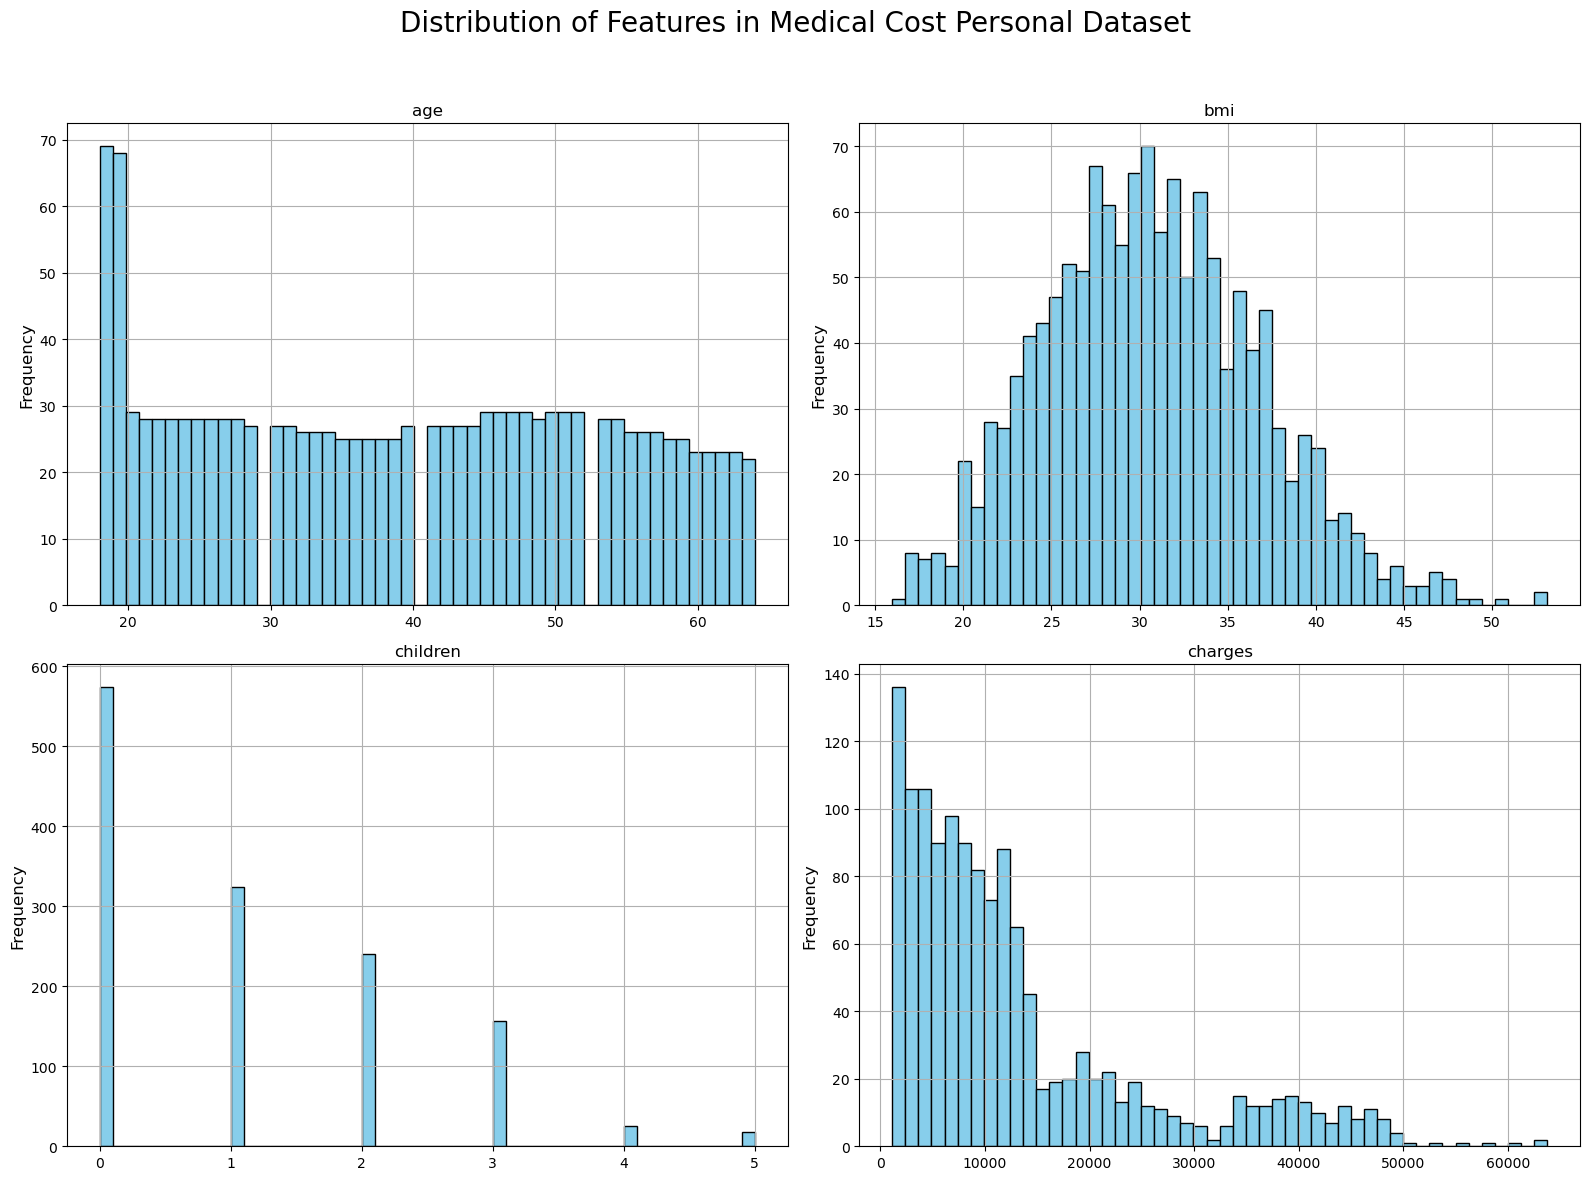

In [5]:
import matplotlib.pyplot as plt

# Customize the histogram
insurance.hist(bins=50, figsize=(16, 12), color='skyblue', edgecolor='black')

# Add labels and titles
plt.suptitle("Distribution of Features in Medical Cost Personal Dataset", fontsize=20)  # Main title
for ax in plt.gcf().axes:  # Iterate through all subplots
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)  # X-axis labels
    ax.set_ylabel("Frequency", fontsize=12)      # Y-axis labels
    ax.tick_params(axis='both', labelsize=10)    # Adjust tick sizes
    ax.grid(True)                                # Add gridlines

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for the main title
plt.show()


In [6]:
print(insurance['smoker'].value_counts())
print(insurance['region'].value_counts())
print(insurance['sex'].value_counts())

smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
sex
male      676
female    662
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

In [8]:
train_set.count()

age         1070
sex         1070
bmi         1070
children    1070
smoker      1070
region      1070
charges     1070
dtype: int64

In [9]:
test_set.count()

age         268
sex         268
bmi         268
children    268
smoker      268
region      268
charges     268
dtype: int64

In [10]:
insurance = train_set.copy()

### Lets now look for correlation within the numerical features

In [11]:
corr_matrix = insurance.corr(numeric_only=True)

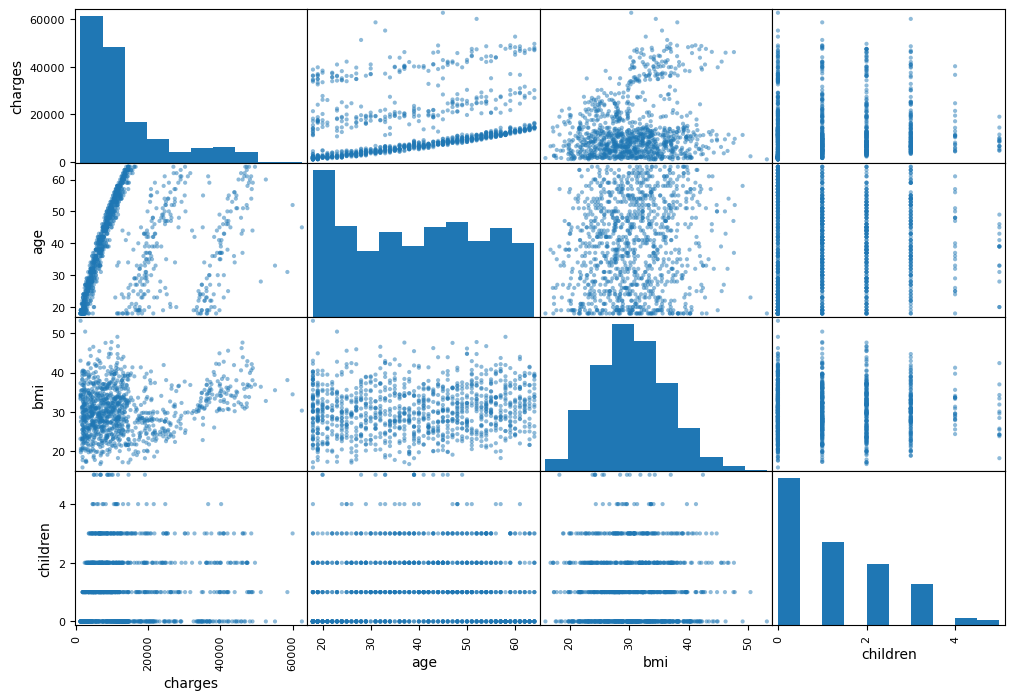

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["charges", "age", "bmi",
              "children",]
scatter_matrix(insurance[attributes], figsize=(12, 8))
plt.show()

In [13]:
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.281721
bmi         0.197316
children    0.071885
Name: charges, dtype: float64

## Prepare the Data for Machine Learning Algorithms

In [14]:
insurance = train_set.drop("charges", axis=1)
insurance_label = train_set["charges"].copy()

### Data cleaning

In [15]:
#checking for missing values in rows
null_rows = insurance.isnull().any(axis=1)
insurance.loc[null_rows].head()

,age,sex,bmi,children,smoker,region


It turns out that there's no any single row in the trainset that is null, but i will still handle missing values in case our model is feed with ffresh data that has missing values.

In [16]:
#Handling missing data using sckit learn simple imputer using the median strategy
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [17]:
import numpy as np
insurance_num = insurance.select_dtypes(include=[np.number])
imputer.fit(insurance_num)

SimpleImputer(strategy='median')

In [18]:
imputer.statistics_[0]

39.5

In [19]:
insurance_num.head()

,age,bmi,children
560,46,19.95,2
1285,47,24.32,0
1142,52,24.86,0
969,39,34.32,5
486,54,21.47,3


In [20]:
insurance_num.index


Index([ 560, 1285, 1142,  969,  486,  170,  277, 1033,  209,  947,
       ...
        330, 1238,  466,  121, 1044, 1095, 1130, 1294,  860, 1126],
      dtype='int64', length=1070)

In [21]:
insurance_num = insurance_num.reset_index(drop=True)


In [22]:
insurance_num.index


RangeIndex(start=0, stop=1070, step=1)

In [23]:
#Transform the training set:
X = imputer.transform(insurance_num)

In [24]:
# Shows the names of the columns transformed by the imputer 
imputer.feature_names_in_

array(['age', 'bmi', 'children'], dtype=object)

In [25]:
# Getting the transformed data from numpy array back to DataFrame with everything same as the original
insurance_num_tr = pd.DataFrame(X, columns=insurance_num.columns, index=insurance_num.index)

Now let's drop some outliers:

In [26]:
# Detecting outlier using isolationforest
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(insurance_num)

In [27]:
outlier_pred

array([-1,  1,  1, ...,  1, -1,  1])

I ignore the outliers

In [28]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Store column names and index before transformation
col_names = insurance_num.columns
index_vals = insurance_num.index

# Initialize and apply StandardScaler
scaler = StandardScaler()
insurance_num_scaled = scaler.fit_transform(insurance_num)  # Now a NumPy array

# Convert back to a DataFrame with original structure
insurance_num = pd.DataFrame(insurance_num_scaled, columns=col_names, index=index_vals)


## Handling non-numeric Attributes

We have only one non-numeric attribute in the  data set, which is the `sex`, `smoker` and `region` attribute. Let's handle them  accordingly.

In [29]:
insurance_cat = insurance[['sex', 'smoker', 'region']]

In [30]:
insurance_cat.head()

,sex,smoker,region
560,female,no,northwest
1285,female,no,northeast
1142,female,no,southeast
969,female,no,southeast
486,female,no,northwest


In [31]:
from sklearn.preprocessing import LabelEncoder

# Select categorical features
insurance_cat = insurance[['sex', 'smoker', 'region']].copy()

# Initialize LabelEncoder
encoder = LabelEncoder()

# Encode binary categorical variables
insurance_cat['sex'] = encoder.fit_transform(insurance_cat['sex'])  # 'male' -> 1, 'female' -> 0
insurance_cat['smoker'] = encoder.fit_transform(insurance_cat['smoker'])  # 'yes' -> 1, 'no' -> 0

# One-Hot Encode 'region' and drop 'northeast'
insurance_cat = pd.get_dummies(insurance_cat, columns=['region'], drop_first=True)

# Display result
print(insurance_cat.head())


      sex  smoker  region_northwest  region_southeast  region_southwest
560     0       0              True             False             False
1285    0       0             False             False             False
1142    0       0             False              True             False
969     0       0             False              True             False
486     0       0              True             False             False


In [32]:
# Ensure both DataFrames have matching indexes before concatenation
insurance_num = insurance_num.reset_index(drop=True)
insurance_cat = insurance_cat.reset_index(drop=True)

# Now safely concatenate
insurance_final = pd.concat([insurance_num, insurance_cat], axis=1)


In [33]:
print(insurance_num.index.equals(insurance_cat.index))  # Should return True
print(insurance_final.index.equals(insurance_num.index))  # Should return True


True
True


# Select and Train a Model

In [34]:
from sklearn.linear_model import LinearRegression

# Train a Linear Regression model on preprocessed data
lin_reg = LinearRegression()
lin_reg.fit(insurance_final, insurance_label)  # Use preprocessed features


LinearRegression()

In [35]:
lin_predictions = lin_reg.predict(insurance_final)
lin_predictions[:10].round(-2)  # -2 = rounded to the nearest hundred

array([ 7100.,  8300.,  9200., 11100., 10100., 17600.,  1100., 23600.,
       12700., 33200.])

In [36]:
insurance_label.iloc[:10].values

array([ 9193.8385 ,  8534.6718 , 27117.99378,  8596.8278 , 12475.3513 ,
       13405.3903 ,  2150.469  , 13747.87235,  6610.1097 , 39047.285  ])

In [37]:
from sklearn.metrics import root_mean_squared_error  

# Calculate RMSE
lin_rmse = root_mean_squared_error(insurance_label, lin_predictions)
print("RMSE:", lin_rmse)


RMSE: 6105.545160099847


In [38]:
error_ratios = lin_predictions[:10].round(-2) / insurance_label.iloc[:10].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-22.8%, -2.7%, -66.1%, 29.1%, -19.0%, 31.3%, -48.8%, 71.7%, 92.1%, -15.0%


In [39]:
from sklearn.tree import DecisionTreeRegressor
d_tree = DecisionTreeRegressor(max_depth=5, random_state=42)

d_tree.fit(insurance_final, insurance_label)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [40]:
d_predictions = d_tree.predict(insurance_final)
d_predictions[:10].round(-2)  # -2 = rounded to the nearest hundred

array([ 8100., 10600., 12300.,  7900., 13900., 15100.,  1800., 13700.,
        6900., 42200.])

In [41]:
from sklearn.metrics import root_mean_squared_error  

# Calculate RMSE
d_tree_rmse = root_mean_squared_error(insurance_label, d_predictions)
print("RMSE:", d_tree_rmse)


RMSE: 4165.644599025778


In [42]:
error_ratios = d_predictions[:10].round(-2) / insurance_label.iloc[:10].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-11.9%, 24.2%, -54.6%, -8.1%, 11.4%, 12.6%, -16.3%, -0.3%, 4.4%, 8.1%


In [43]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

rf_reg.fit(insurance_final, insurance_label)


RandomForestRegressor(random_state=42)

In [44]:
insurance_predictions = rf_reg.predict(insurance_final)
insurance_predictions[:10].round(-2)  # -2 = rounded to the nearest hundred

array([10000., 10400., 19000.,  9600., 12700., 13800.,  2400., 13800.,
        6500., 39500.])

In [45]:
from sklearn.metrics import root_mean_squared_error  
   
# Calculate RMSE
rf_rmse = root_mean_squared_error(insurance_label, insurance_predictions)
print("RMSE:", rf_rmse)


RMSE: 1931.370165235786


In [46]:
error_ratios = insurance_predictions[:10].round(-2) / insurance_label.iloc[:10].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

8.8%, 21.9%, -29.9%, 11.7%, 1.8%, 2.9%, 11.6%, 0.4%, -1.7%, 1.2%


In [47]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(insurance_final, insurance_label)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [48]:
insurance_predictions = xgb_model.predict(insurance_final)
insurance_predictions[:10].round(-2)  # -2 = rounded to the nearest hundred

array([ 9000., 11400., 13000.,  9300., 12300., 14100.,  3100., 13900.,
        8000., 40400.], dtype=float32)

In [49]:
   
# Calculate RMSE
xgb_rmse = root_mean_squared_error(insurance_label, insurance_predictions)
print("RMSE:", xgb_rmse)


RMSE: 3933.3468912456324


In [50]:
error_ratios = insurance_predictions[:10].round(-2) / insurance_label.iloc[:10].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-2.1%, 33.6%, -52.1%, 8.2%, -1.4%, 5.2%, 44.2%, 1.1%, 21.0%, 3.5%


# Cross validation

In [51]:
from sklearn.model_selection import cross_val_score
rf_rmse_cv = -cross_val_score(rf_reg, insurance_final, insurance_label, scoring="neg_root_mean_squared_error", cv=10)

In [52]:
pd.Series(rf_rmse_cv).describe()

count      10.000000
mean     5006.557169
std       533.737405
min      3881.359502
25%      4798.949520
50%      5117.550777
75%      5351.364112
max      5765.524437
dtype: float64

In [53]:
from sklearn.model_selection import cross_val_score
d_tree_rmse_cv = -cross_val_score(d_tree, insurance_final, insurance_label, scoring="neg_root_mean_squared_error", cv=10)

In [54]:
pd.Series(d_tree_rmse_cv).describe()

count      10.000000
mean     4753.991561
std       568.023645
min      3510.176347
25%      4609.243241
50%      4877.733383
75%      4969.599237
max      5728.254528
dtype: float64

In [55]:
from sklearn.model_selection import cross_val_score
lin_rmse_cv = -cross_val_score(lin_reg, insurance_final, insurance_label, scoring="neg_root_mean_squared_error", cv=10)

In [56]:
pd.Series(lin_rmse_cv).describe()

count      10.000000
mean     6133.083926
std       548.885351
min      5233.826835
25%      5888.661689
50%      6100.717616
75%      6289.473935
max      7281.083736
dtype: float64

In [57]:
from sklearn.model_selection import cross_val_score
xgb_rmse_cv = -cross_val_score(xgb_model, insurance_final, insurance_label, scoring="neg_root_mean_squared_error", cv=10)

In [58]:
pd.Series(xgb_rmse_cv).describe()

count      10.000000
mean     4624.096557
std       595.858241
min      3358.717508
25%      4603.456301
50%      4726.776560
75%      4885.090940
max      5440.672510
dtype: float64

In [59]:
xgb_rmse.mean()

3933.3468912456324

In [60]:

# Summary of model performance
model_results = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "RMSE (Test)": [lin_rmse, d_tree_rmse, rf_rmse, xgb_rmse],
    "CV RMSE (Mean)": [lin_rmse_cv.mean(), d_tree_rmse_cv.mean(), rf_rmse_cv.mean(), xgb_rmse_cv.mean()],
    "CV RMSE (Std Dev)": [lin_rmse_cv.std(), d_tree_rmse_cv.std(), rf_rmse_cv.std(), xgb_rmse_cv.std()]
}

results_df = pd.DataFrame(model_results)
print("Model Performance Summary")
display(results_df)


Model Performance Summary


,Model,RMSE (Test),CV RMSE (Mean),CV RMSE (Std Dev)
0,Linear Regression,6105.545160,6133.083926,520.718365
1,Decision Tree,4165.644599,4753.991561,538.874545
2,Random Forest,1931.370165,5006.557169,506.347762
3,XGBoost,3933.346891,4624.096557,565.280761


# Fine-Tune Your Model

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from scipy.stats import randint, uniform


In [82]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(200, 500),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(2, 6),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0.1, 1.0),              # Avoid over-splitting
    'subsample': uniform(0.6, 0.4),           # Bagging-like regularization
    'colsample_bytree': uniform(0.6, 0.4),    # Column subsampling
    'reg_alpha': uniform(0, 1.0),             # L1 regularization
    'reg_lambda': uniform(1.0, 5.0),          # L2 regularization
}


cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)


xgb_base = XGBRegressor(random_state=42, tree_method='hist')

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=60,
    scoring='neg_root_mean_squared_error',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(insurance_final, insurance_label)


Fitting 15 folds for each of 60 candidates, totalling 900 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_t...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B9E0165610>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B9E0165B50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B9E0167740>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [90]:
best_xgb = search.best_estimator_
print("Best Hyperparameters:", search.best_params_)

Best Hyperparameters: {'colsample_bytree': 0.9861021229056552, 'gamma': 0.7070342476866847, 'learning_rate': 0.03759991820225434, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 208, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.993578407670862, 'subsample': 0.602208846849441}


In [91]:
best_model = search.best_estimator_
print("Best Hyperparameters:", search.best_params_)

# Test performance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    insurance_final, insurance_label, test_size=0.2, random_state=42
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE after tuning with regularization: {rmse:.2f}")


Best Hyperparameters: {'colsample_bytree': 0.9861021229056552, 'gamma': 0.7070342476866847, 'learning_rate': 0.03759991820225434, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 208, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 1.993578407670862, 'subsample': 0.602208846849441}
Test RMSE after tuning with regularization: 5251.63


In [92]:
insurance_label.mean()

13346.089736364485

In [ ]:

percentage_change = ((rmse - insurance_label.mean()) / insurance_label.mean()) * 100
print(f"Change: {percentage_change:.2f}%")

Change: -60.65%
